# Pleiotropic correction  
Pleiotropic genes are genes that influence multiple, seemingly unrelated biological processes or traits. In gene regulatory networks, this means a single transcription factor (TF) may appear to regulate a broad and diverse set of genes, not necessarily because it is biologically driving them, but due to statistical or network artifacts. In the context of VIPER and pyVIPER, this can lead to inflated activity scores for such transcription factors, especially when they share many targets with more specific regulators. To address this, the original VIPER implementation in R included a pleiotropy correction step (via the shadowRegulon function) to penalize TFs that may be masking others due to shared targets. This correction helps ensure that protein activity inference reflects true regulatory influence rather than pleiotropic noise. The same logic has now been implemented in pyVIPER to enhance its biological accuracy and replicate the robustness of the original R version.

# STEP 1: Load a gene expression signature for single-cells 

In [1]:
# STEP 1: import libraries 
import numpy as np
import pandas as pd
from scipy.stats import norm
import scanpy as sc
import pyviper
import matplotlib.pyplot as plt 
from itertools import combinations


/Users/friva/miniconda3/envs/scenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Step 2: Load the data and gene expression signature
 
data_location = "https://zenodo.org/records/10059791/files/"
gene_expr_path = data_location + "Tutorial_1_gExpr_fibroblast_5802.tsv.gz"
gene_expr_signature = pd.read_csv(gene_expr_path, sep="\t")
gene_expr_signature = sc.AnnData(gene_expr_signature)
gene_expr_signature



AnnData object with n_obs × n_vars = 5802 × 5000

# STEP 2: Load an inspect a lineage-specific gene regulatory network

In [3]:
# Step 3: Load ARACNe network
network_path = data_location + "fibroblast-net.tsv"
network = pd.read_csv(network_path, delimiter="\t")
network_interactome = pyviper.Interactome('fibroblasts', network) 
network_interactome.size() # show number of regulons in the Interactome 
network_interactome.net_table.head() 
network_interactome.filter_targets(gene_expr_signature.var_names)

Removed 3047484 targets.


# STEP 3: Apply Pleiotropic Correction

In [4]:
#Step 4: Run ShadowRegulon_py function 
#Parameters:
# ss : pandas.Series, Gene expression signature (gene names as index, expression values as data).   
# nes : pandas.Series, Normalized enrichment scores from a previous VIPER run (TF names as index).
# regul : dict Regulon object ,  dictionary mapping each TF to a dict with 'tfmode' and 'likelihood' values for its target genes.
# regulators : float or int, optional (default=0.05)
    #- If < 1: p-value threshold to select significant regulators based on NES.
    #   - If >= 1: number of top regulators to consider for pleiotropy testing.
    
# shadow : float, optional (default=0.05) P-value threshold for determining significant pleiotropy (shadow) effect.
# targets : int, optional (default=10), Minimum number of overlapping target genes between TF pairs to consider them for pleiotropy analysis.    
# penalty : float, optional (default=2),  Penalization factor to down-weight pleiotropic interactions (must be >1). A value of 1 means no correction. 
# method : str, optional (default='absolute')
    #Method for applying correction:
    #   - 'absolute': penalize TFs that are dominated by another TF with shared targets.
    #   - 'adaptive': penalization is scaled based on the relative strength (p-value) difference.


def shadowRegulon_py(ss, nes, regul, regulators=0.05, shadow=0.05, targets=10, penalty=2, method='absolute'):
    method = method.lower()

    nes = pd.Series(nes) if not isinstance(nes, pd.Series) else nes # Ensure 'nes' is a pandas Series (if not already)
    pval_vals = 2 * norm.sf(np.abs(nes.values)) # Compute two-tailed p-values for each NES using the standard normal distribution
    pval = pd.Series(pval_vals, index=nes.index)  # Create a Series of p-values with TF names as the index
 
 # Determine which transcription factors (TFs) to include based on the 'regulators' parameter
    if regulators < 1:
        tfs = pval[pval < regulators].index.tolist() # If regulators is a float < 1, treat it as a p-value threshold — keep TFs with p-value below this threshold
    else:
        tfs = pval.sort_values().index[:int(regulators)].tolist()  # If regulators is an integer >= 1, select the top N TFs with the smallest p-values
    tfs = [tf for tf in tfs if "--" not in tf]  # Exclude TFs that contain '--', which are usually artifacts or improperly formatted names
    if len(tfs) < 2: 
        return regul    # If fewer than 2 valid TFs are found, return the original regulon unmodified

    result_dict = {} # Dictionary to store pleiotropy test results for TF pairs
    tests = {} # Dictionary to count how many comparisons each TF is involved in


    for tf1 in tfs:  # Loop over each transcription factor (TF) as the "primary" TF
        reg_tmp = {} # Temporary dictionary to store pleiotropy candidates for tf1
        for tf2 in tfs:
            if tf2 == tf1 or tf1 not in regul or tf2 not in regul: # Loop again to compare tf1 with every other TF (tf2)
                continue
            common_targets = set(regul[tf1]["tfmode"]) & set(regul[tf2]["tfmode"]) # Find the set of common target genes between tf1 and tf2

            if len(common_targets) < targets:
                continue
            reg_tmp[tf2] = {
                "tfmode": [regul[tf1]["tfmode"][t] for t in common_targets],
                "likelihood": [regul[tf1]["likelihood"][t] for t in common_targets],
                "names": list(common_targets) 
            } # Store information about the overlap:
            # - tfmode values for common targets (from tf1's perspective)
            # - likelihood values for the same targets
            # - names of the shared target genes

        tf1_targets = list(regul[tf1]["tfmode"].keys())  # Get the list of all target genes regulated by tf1
        ss_tf1 = pd.Series({g: ss[g] for g in tf1_targets if g in ss})  # Create a Series of gene expression signature values for tf1's targets (only those present in 'ss')

        s2 = ss_tf1.rank() / (len(ss_tf1) + 1) * 2 - 1  # Rank-transform and scale s2 to lie in [-1, 1] to reflect activation state
        s1 = np.abs(s2) * 2 - 1  # s1 reflects magnitude of activation regardless of direction, scaled to [-1, 1]
        s1 += (1 - s1.max()) / 2 # Normalize s1 to ensure it has maximum value close to 1 (avoids infinities in next step)

        s1 = pd.Series(norm.ppf(s1 / 2 + 0.5), index=s2.index)  # Transform s1 to a normal distribution using the inverse CDF (probability integral transform)


        sign_nes = np.sign(nes.get(tf1, 1)) or 1   # Determine the sign of tf1's NES (normalized enrichment score); default to +1 if not found
        s2 = pd.Series(norm.ppf(s2 / 2 + 0.5) * sign_nes, index=s2.index) # Convert s2 to normal distribution as well, adjusting sign based on NES direction

        pvals_tf1 = {} # Dictionary to store p-values for pleiotropy between tf1 and each tf2
        for tf2, data in reg_tmp.items(): # List of shared target genes between tf1 and tf2
            genes = data["names"]
            valid_genes = [g for g in genes if g in s1.index] # Filter shared genes to only those also in s1 (i.e., valid for calculation)
            if len(valid_genes) < targets:
                continue # Skip this tf pair if not enough overlapping valid targets
            tfmode_vals = np.array([data["tfmode"][i] for i, g in enumerate(genes) if g in valid_genes]) # Get regulatory mode values for the valid genes
            likelihood_vals = np.array([data["likelihood"][i] for i, g in enumerate(genes) if g in valid_genes]) # Get likelihood/confidence values for the valid genes
            s1_vals = s1[valid_genes].values  # s1 values for the valid genes (directionless activation strength)
            s2_vals = s2[valid_genes].values # s2 values for the valid genes (directional activation strength)

            sum1 = np.sum(tfmode_vals * likelihood_vals * s2_vals)   # Weighted directional score (activation/inhibition with direction)
            sum2 = np.sum((1 - np.abs(tfmode_vals)) * likelihood_vals * s1_vals)  # Weighted undirected penalty based on weak regulation (values close to 0)
            ww = likelihood_vals / np.max(likelihood_vals) # Normalize likelihoods for weighting
            score = (np.abs(sum1) + sum2 * (sum2 > 0)) / np.sum(likelihood_vals) * np.sign(sum1 or 1) * np.sqrt(np.sum(ww ** 2)) # Composite pleiotropy score combining directionality and penalty
            pvals_tf1[tf2] = norm.sf(score)   # Convert score to one-sided p-value (shadow effect from tf2 on tf1)

        result_dict[tf1] = pvals_tf1 # Save all tf2 p-values for this tf1
        tests[tf1] = len(pvals_tf1) # Record how many TFs were tested against tf1

    tf_pairs = list(combinations(tfs, 2))  # Generate all unique unordered pairs of transcription factors (TFs) for pleiotropy testing
    records = []
    for tf1, tf2 in tf_pairs:
        p1 = result_dict.get(tf1, {}).get(tf2, np.nan)
        p2 = result_dict.get(tf2, {}).get(tf1, np.nan) # Retrieve p-values for shadowing from tf2 → tf1 and tf1 → tf2
        if not np.isnan(p1) and not np.isnan(p2):  # Only keep the pair if both directional p-values exist (i.e., were computed)
            records.append((tf1, tf2, p1, p2)) 

    df_pairs = pd.DataFrame(records, columns=["TF1", "TF2", "P12", "P21"])  # Store results in a DataFrame for easy filtering and analysis

    if df_pairs.empty:
        return regul # If no valid TF pairs remain, return the unmodified regulon

    if method == 'absolute':  # Use the "absolute" method to detect asymmetric pleiotropy (one TF masks the other)
        sig_1 = df_pairs[(df_pairs["P12"] < shadow) & (df_pairs["P21"] > shadow)]
        sig_2 = df_pairs[(df_pairs["P21"] < shadow) & (df_pairs["P12"] > shadow)].copy()
        sig_2[["TF1", "TF2"]] = sig_2[["TF2", "TF1"]]
        significant = pd.concat([sig_1, sig_2])

        for _, row in significant.iterrows(): # For each asymmetric pair (tf2 shadows tf1), apply a penalty to tf1's targets
            tf1, tf2 = row["TF1"], row["TF2"]
            if tf1 not in regul or tf2 not in regul:  # Safety check: skip if one of the TFs is missing from the regulon
                continue
            common_genes = set(regul[tf1]["tfmode"]) & set(regul[tf2]["tfmode"])   # Identify overlapping genes regulated by both TFs
            for gene in common_genes:   # Apply penalty only if the gene has a defined likelihood under tf1
                if gene in regul[tf1]["likelihood"]:
                    regul[tf1]["likelihood"][gene] /= penalty ** (1 / tests[tf1]) # Penalize likelihood by reducing its value to down-weight pleiotropic effects

    elif method == 'adaptive':  # If using the "adaptive" method, calculate a directional penalty based on the asymmetry in shadowing
        df_pairs["diff"] = np.log10(df_pairs["P21"] + 1e-10) - np.log10(df_pairs["P12"] + 1e-10) # Compute log-scale difference in p-values for each TF pair to measure asymmetry in shadowing.
        # Small constant 1e-10 added to avoid log(0).
        for _, row in df_pairs.iterrows():
            tf1, tf2 = row["TF1"], row["TF2"]
            if np.isnan(row["diff"]): # Skip the pair if difference could not be computed
                continue
            if row["diff"] > 0:  # tf2 significantly shadows tf1; keep original order
                weight = row["diff"]
            else:
                tf1, tf2 = tf2, tf1   # tf1 shadows tf2; swap direction and take positive weight
                weight = -row["diff"]
            if tf1 not in regul or tf2 not in regul:    # Safety check
                continue
            common_genes = set(regul[tf1]["tfmode"]) & set(regul[tf2]["tfmode"])
            for gene in common_genes:    # Penalize the likelihood of the TF that is being shadowed
                if gene in regul[tf1]["likelihood"]:
                    regul[tf1]["likelihood"][gene] /= (1 + weight) ** (penalty / tests[tf1])  # The penalty is modulated by both the strength of asymmetry (weight) and the number of comparisons (tests[tf1])

    return regul, df_pairs # Return the regulon object with updated (penalized) likelihoods




# Step 4: RUN pyVIPER pre and post Correction

In [5]:
# Step 4: Run pyVIPER before correction
ProtAct_original = pyviper.viper(
    gex_data=gene_expr_signature,
    interactome=network_interactome,
    enrichment="narnea",
    eset_filter=False,
    njobs=1
)

ProtAct_original.to_df() # NES matrix


Preparing the association scores
Computing regulons enrichment with NaRnEa


/Users/friva/miniconda3/envs/scenv/lib/python3.9/site-packages/pyviper/NaRnEA/NaRnEA_classic.py:200: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_table['mor'].replace(1 ,0.999, inplace= True)
/Users/friva/miniconda3/envs/scenv/lib/python3.9/site-packages/pyviper/NaRnEA/NaRnEA_classic.py:201: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediat

reordering genes
Calculating DES...
Calculating UES...
Calculating NES...
Calculating PES...


,AAMP,AATF,ABCA1,ABCA12,ABCA3,ABCA7,ABCA8,ABCB1,ABCB4,ABCB5,...,ZSWIM5,ZSWIM6,ZSWIM7,ZWINT,ZXDA,ZXDB,ZXDC,ZYX,ZZEF1,ZZZ3
T1_AAACCTGAGATGTCGG,4.721734,-6.619827,7.008813,1.861781,1.856598,-0.870238,14.555466,-0.624870,-0.835634,0.415443,...,-1.877274,3.158300,-7.010895,-0.767114,-2.016624,1.473462,2.726915,5.796276,2.409854,-2.594848
T1_AACTGGTTCTAACGGT,-7.194335,7.539468,9.435460,4.098622,-0.469555,1.067867,-18.895628,1.415011,-0.808934,1.093563,...,2.213714,-3.225383,-7.223655,0.832463,1.240214,-1.571365,-1.406364,12.754583,1.835522,2.965396
T1_AAGGTTCGTGTCAATC,8.892053,-9.453808,-10.276663,3.200662,-1.276665,0.668082,20.592220,0.475050,-0.928214,0.497169,...,1.669964,3.418652,-8.993046,-1.793087,-0.958978,-2.596414,1.049315,-11.111879,-1.967781,-2.485891
T1_ACAGCCGTCAAGCCTA,7.851400,6.905695,9.582031,-2.862549,-0.883946,-1.470669,23.073534,-0.614457,1.140870,0.949438,...,-1.179793,-2.539163,-6.815755,-1.127239,-1.584070,1.258887,2.088022,-11.702254,2.173031,2.511354
T1_AGACGTTAGGCGACAT,7.647149,6.960122,-8.842428,2.599533,0.562035,-0.706634,-15.241218,0.168039,2.954947,-0.942813,...,1.897963,-2.463266,-9.299325,0.864452,2.009431,-1.286205,-2.902146,8.258941,-2.184118,3.036592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T24_TTGCGTCCAGACAAAT,3.936121,3.912197,-7.635411,-2.268020,0.557243,-1.325284,10.868199,0.819879,-1.106013,1.725982,...,-2.446716,2.681818,5.761685,0.989011,-2.355896,-0.963434,1.598874,6.739289,2.979156,1.230419
T24_TTGCGTCCATTAACCG,-7.200858,7.800428,8.200803,-2.343332,-1.674645,1.416084,-19.099210,0.633930,-0.581409,-1.299787,...,1.167182,-2.944020,7.269258,-0.951725,-1.750199,1.705520,-1.838097,10.667582,1.591999,2.984735
T24_TTTATGCTCCTTTACA,-7.106027,8.048133,-8.375441,2.619907,0.908485,-2.109688,20.656478,-0.355086,0.885489,-0.590344,...,1.123289,2.807651,6.441253,1.058726,1.446795,-1.593226,1.463587,-10.230168,1.784666,2.937815
T24_TTTCCTCCACCGGAAA,-6.272371,-5.982345,-6.917609,-3.526581,0.889230,-1.033967,-11.206110,0.544282,-1.331863,0.820132,...,1.272478,-3.339912,5.365629,-2.224107,-1.598793,-1.075789,0.956203,-6.464254,-1.202947,2.896665


In [6]:

# Step 5: Apply pleiotropy correction
# ---------------------------------------

# Ensure proper format for gene expression signature
signature = pd.Series(
    np.array(gene_expr_signature.X.mean(axis=0)).flatten(),
    index=gene_expr_signature.var_names
)

# Get NES values from original VIPER run
NES_matrix = ProtAct_original.to_df()
NES_vals = pd.Series(NES_matrix.mean(axis=0).values, index=NES_matrix.columns)

# Build regulon from Interactome manually
net_table = network_interactome.net_table
regulon = {}

for tf in net_table['regulator'].unique():
    tf_df = net_table[net_table['regulator'] == tf]
    regulon[tf] = {
        "tfmode": dict(zip(tf_df['target'], tf_df['mor'])),
        "likelihood": dict(zip(tf_df['target'], tf_df['likelihood']))
    }

# Apply pleiotropy correction
corrected_regulon, df_pairs = shadowRegulon_py(
    ss=signature,
    nes=NES_vals,
    regul=regulon,
    regulators=0.05,
    shadow=0.05,
    targets=10,
    penalty=2,
    method='absolute'
)

# Manually convert corrected_regulon dict to net_table DataFrame
rows = []
for tf, reg_data in corrected_regulon.items():
    for target in reg_data['tfmode']:
        rows.append({
            'regulator': tf,
            'target': target,
            'mor': reg_data['tfmode'][target],
            'likelihood': reg_data['likelihood'][target]
        })

corrected_net_table = pd.DataFrame(rows)

# Create corrected Interactome from table
corrected_interactome = pyviper.Interactome(name="fibroblast_corrected", net_table=corrected_net_table)



# Obtain Shadow Pairs after correction 

In [9]:
# Step: Filter relaxed-threshold shadow pairs (asymmetric shadowing)
sig_1 = df_pairs[(df_pairs["P12"] < 0.3) & (df_pairs["P21"] > 0.3)]
sig_2 = df_pairs[(df_pairs["P21"] < 0.3) & (df_pairs["P12"] > 0.3)].copy()
sig_2[["TF1", "TF2"]] = sig_2[["TF2", "TF1"]]  # Flip columns so TF1 is always the one being shadowed

# Combine and annotate shadow effect
shadow_pairs_df = pd.concat([sig_1, sig_2])
shadow_pairs_df["Shadow"] = shadow_pairs_df.apply(lambda row: f"{row['TF1']} -> {row['TF2']}", axis=1)

# Print all shadow effects as a neat column
print("Detected relaxed-threshold shadow pairs:\n")
print(shadow_pairs_df[["Shadow"]].to_string(index=False))


Detected relaxed-threshold shadow pairs:

              Shadow
      ABCA8 -> ABCC9
   ABCA8 -> ARHGAP12
      ABCA8 -> BIRC3
         ABCA8 -> C3
       ABCA8 -> CCL2
       ABCA8 -> CCNK
       ABCA8 -> CD63
        ABCA8 -> CFB
      ABCA8 -> CXCL3
       ABCA8 -> ENO1
      ABCA8 -> FOSL1
      ABCA8 -> HLA-A
      ABCA8 -> HLA-C
       ABCA8 -> IGF1
     ABCA8 -> LGALS1
        ABCA8 -> MIF
       ABCA8 -> NACA
     ABCA8 -> NFATC2
      ABCA8 -> NR4A2
       ABCA8 -> SAFB
      ABCA8 -> SNAI2
      ABCA8 -> SRP72
      ABCA8 -> TDRD3
       ABCA8 -> TNXB
      ABCA8 -> TRIB1
   ABCC9 -> ARHGAP12
      ABCC9 -> BNIP3
       ABCC9 -> CCL2
        ABCC9 -> CFB
       ABCC9 -> EBF1
       ABCC9 -> EMP1
     ABCC9 -> LGALS1
        ABCC9 -> MYC
      ABCC9 -> NELFB
       ABCC9 -> RPS3
       ABCC9 -> SDC3
     ABCC9 -> SEMA6A
       ABCC9 -> STK4
         ABL2 -> ADM
     ABL2 -> ANGPTL4
    ABL2 -> ARHGAP12
         ABL2 -> B2M
      ABL2 -> BAIAP2
       ABL2 -> BNIP3
        ABL2 

In [11]:
# ---------------------------------------
# Step 6: Run pyVIPER after correction
# ---------------------------------------
ProtAct_corrected = pyviper.viper(
    gex_data=gene_expr_signature,
    interactome=corrected_interactome,
    enrichment="narnea",
    eset_filter=False,
    njobs=1
)

Preparing the association scores
Computing regulons enrichment with NaRnEa


/Users/friva/miniconda3/envs/scenv/lib/python3.9/site-packages/pyviper/NaRnEA/NaRnEA_classic.py:200: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_table['mor'].replace(1 ,0.999, inplace= True)
/Users/friva/miniconda3/envs/scenv/lib/python3.9/site-packages/pyviper/NaRnEA/NaRnEA_classic.py:201: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediat

reordering genes
Calculating DES...
Calculating UES...
Calculating NES...
Calculating PES...


In [21]:
# Step 7: Display Protein Activity for both original and corrected regulons

ProtAct_original 
ProtAct_corrected



AnnData object with n_obs × n_vars = 5802 × 6413
    uns: 'gex_data'
    layers: 'pes'

In [22]:
ProtAct_original.to_df() #NES matrix before correction


,AAMP,AATF,ABCA1,ABCA12,ABCA3,ABCA7,ABCA8,ABCB1,ABCB4,ABCB5,...,ZSWIM5,ZSWIM6,ZSWIM7,ZWINT,ZXDA,ZXDB,ZXDC,ZYX,ZZEF1,ZZZ3
T1_AAACCTGAGATGTCGG,4.721734,-6.619827,7.008813,1.861781,1.856598,-0.870238,14.555466,-0.624870,-0.835634,0.415443,...,-1.877274,3.158300,-7.010895,-0.767114,-2.016624,1.473462,2.726915,5.796276,2.409854,-2.594848
T1_AACTGGTTCTAACGGT,-7.194335,7.539468,9.435460,4.098622,-0.469555,1.067867,-18.895628,1.415011,-0.808934,1.093563,...,2.213714,-3.225383,-7.223655,0.832463,1.240214,-1.571365,-1.406364,12.754583,1.835522,2.965396
T1_AAGGTTCGTGTCAATC,8.892053,-9.453808,-10.276663,3.200662,-1.276665,0.668082,20.592220,0.475050,-0.928214,0.497169,...,1.669964,3.418652,-8.993046,-1.793087,-0.958978,-2.596414,1.049315,-11.111879,-1.967781,-2.485891
T1_ACAGCCGTCAAGCCTA,7.851400,6.905695,9.582031,-2.862549,-0.883946,-1.470669,23.073534,-0.614457,1.140870,0.949438,...,-1.179793,-2.539163,-6.815755,-1.127239,-1.584070,1.258887,2.088022,-11.702254,2.173031,2.511354
T1_AGACGTTAGGCGACAT,7.647149,6.960122,-8.842428,2.599533,0.562035,-0.706634,-15.241218,0.168039,2.954947,-0.942813,...,1.897963,-2.463266,-9.299325,0.864452,2.009431,-1.286205,-2.902146,8.258941,-2.184118,3.036592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T24_TTGCGTCCAGACAAAT,3.936121,3.912197,-7.635411,-2.268020,0.557243,-1.325284,10.868199,0.819879,-1.106013,1.725982,...,-2.446716,2.681818,5.761685,0.989011,-2.355896,-0.963434,1.598874,6.739289,2.979156,1.230419
T24_TTGCGTCCATTAACCG,-7.200858,7.800428,8.200803,-2.343332,-1.674645,1.416084,-19.099210,0.633930,-0.581409,-1.299787,...,1.167182,-2.944020,7.269258,-0.951725,-1.750199,1.705520,-1.838097,10.667582,1.591999,2.984735
T24_TTTATGCTCCTTTACA,-7.106027,8.048133,-8.375441,2.619907,0.908485,-2.109688,20.656478,-0.355086,0.885489,-0.590344,...,1.123289,2.807651,6.441253,1.058726,1.446795,-1.593226,1.463587,-10.230168,1.784666,2.937815
T24_TTTCCTCCACCGGAAA,-6.272371,-5.982345,-6.917609,-3.526581,0.889230,-1.033967,-11.206110,0.544282,-1.331863,0.820132,...,1.272478,-3.339912,5.365629,-2.224107,-1.598793,-1.075789,0.956203,-6.464254,-1.202947,2.896665


In [23]:
ProtAct_corrected.to_df()  # NES matrix after correction


,AAMP,AATF,ABCA1,ABCA12,ABCA3,ABCA7,ABCA8,ABCB1,ABCB4,ABCB5,...,ZSWIM5,ZSWIM6,ZSWIM7,ZWINT,ZXDA,ZXDB,ZXDC,ZYX,ZZEF1,ZZZ3
T1_AAACCTGAGATGTCGG,4.721734,-6.619827,7.008813,1.861781,1.856598,-0.870238,14.530732,-0.624870,-0.835634,0.415443,...,-1.877274,3.158300,-7.010895,-0.767114,-2.016624,1.473462,2.726915,5.796276,2.409854,-2.594848
T1_AACTGGTTCTAACGGT,-7.194335,7.539468,9.435460,4.098622,-0.469555,1.067867,-18.877764,1.415011,-0.808934,1.093563,...,2.213714,-3.225383,-7.223655,0.832463,1.240214,-1.571365,-1.406364,12.754583,1.835522,2.965396
T1_AAGGTTCGTGTCAATC,8.892053,-9.453808,-10.276663,3.200662,-1.276665,0.668082,20.565485,0.475050,-0.928214,0.497169,...,1.669964,3.418652,-8.993046,-1.793087,-0.958978,-2.596414,1.049315,-11.111879,-1.967781,-2.485891
T1_ACAGCCGTCAAGCCTA,7.851400,6.905695,9.582031,-2.862549,-0.883946,-1.470669,23.047020,-0.614457,1.140870,0.949438,...,-1.179793,-2.539163,-6.815755,-1.127239,-1.584070,1.258887,2.088022,-11.702254,2.173031,2.511354
T1_AGACGTTAGGCGACAT,7.647149,6.960122,-8.842428,2.599533,0.562035,-0.706634,-15.197225,0.168039,2.954947,-0.942813,...,1.897963,-2.463266,-9.299325,0.864452,2.009431,-1.286205,-2.902146,8.258941,-2.184118,3.036592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T24_TTGCGTCCAGACAAAT,3.936121,3.912197,-7.635411,-2.268020,0.557243,-1.325284,10.821734,0.819879,-1.106013,1.725982,...,-2.446716,2.681818,5.761685,0.989011,-2.355896,-0.963434,1.598874,6.739289,2.979156,1.230419
T24_TTGCGTCCATTAACCG,-7.200858,7.800428,8.200803,-2.343332,-1.674645,1.416084,-19.063466,0.633930,-0.581409,-1.299787,...,1.167182,-2.944020,7.269258,-0.951725,-1.750199,1.705520,-1.838097,10.667582,1.591999,2.984735
T24_TTTATGCTCCTTTACA,-7.106027,8.048133,-8.375441,2.619907,0.908485,-2.109688,20.614177,-0.355086,0.885489,-0.590344,...,1.123289,2.807651,6.441253,1.058726,1.446795,-1.593226,1.463587,-10.230168,1.784666,2.937815
T24_TTTCCTCCACCGGAAA,-6.272371,-5.982345,-6.917609,-3.526581,0.889230,-1.033967,-11.177153,0.544282,-1.331863,0.820132,...,1.272478,-3.339912,5.365629,-2.224107,-1.598793,-1.075789,0.956203,-6.464254,-1.202947,2.896665


 After applying the pleiotropic correction and obtaining the corrected NES matrix, we evaluated whether the correction had the expected effect by comparing the corrected and original NES scores. To assess this, we identified the top 10 transcription factors (TFs) with the largest absolute differences in NES values before and after the correction. These TFs were used to illustrate how the pleiotropic adjustment downregulated overly broad or non-specific regulators, indicating that the correction was successfully applied.

In [24]:
#Step8: Check differences in NES values between original and corrected regulons


# Convert to DataFrames
df_original = ProtAct_original.to_df()
df_corrected = ProtAct_corrected.to_df()

# Ensure same index and column alignment
df_original, df_corrected = df_original.align(df_corrected, join='inner', axis=1)

# Calculate difference: corrected - original
df_diff = df_corrected - df_original

# Display top differences
print("Top differences in NES (corrected - original):")
print(df_diff.abs().mean().sort_values(ascending=False).head(10))

# Optionally: Save or inspect full difference matrix
#df_diff.to_csv("NES_difference_matrix.csv")


Top differences in NES (corrected - original):
GATA6      0.178486
BCL6       0.169241
DEPTOR     0.134095
F10        0.117783
SLC16A1    0.111397
SDC3       0.107551
ADAMTS1    0.097872
CEBPG      0.094119
EDNRB      0.082607
SMARCD2    0.075013
dtype: float64


In [25]:
#Step 9: Side-by-side comparison of top TFs before and after correction

# Define top TFs
top_tfs = ["GATA6", "BCL6"]

# Get NES DataFrames
df_original = ProtAct_original.to_df()[top_tfs]
df_corrected = ProtAct_corrected.to_df()[top_tfs]

# Rename columns to distinguish
df_original.columns = [f"{tf}_original" for tf in top_tfs]
df_corrected.columns = [f"{tf}_corrected" for tf in top_tfs]

# Concatenate side by side
df_combined = pd.concat([df_original, df_corrected], axis=1)

# Round for readability
df_combined = df_combined.round(3)

# Display side-by-side NES scores
print("Side-by-side NES Scores (Original and Corrected):")
print(df_combined)


Side-by-side NES Scores (Original and Corrected):
                      GATA6_original  BCL6_original  GATA6_corrected  \
T1_AAACCTGAGATGTCGG            9.143          5.897            9.003   
T1_AACTGGTTCTAACGGT          -12.747         -8.455          -12.599   
T1_AAGGTTCGTGTCAATC           11.791          9.672           11.601   
T1_ACAGCCGTCAAGCCTA           11.504         11.400           11.270   
T1_AGACGTTAGGCGACAT           -9.997        -10.685           -9.858   
...                              ...            ...              ...   
T24_TTGCGTCCAGACAAAT           8.492          7.478            8.300   
T24_TTGCGTCCATTAACCG         -11.699         -8.286          -11.530   
T24_TTTATGCTCCTTTACA          12.691          6.891           12.469   
T24_TTTCCTCCACCGGAAA          -7.348          5.930           -7.180   
T24_TTTGCGCTCCTTTCGG           9.846          7.115            9.626   

                      BCL6_corrected  
T1_AAACCTGAGATGTCGG            5.794  
T1_AACT

In [26]:
ProtAct_original.to_df(layer="pes") #PES matrix before correction

,AAMP,AATF,ABCA1,ABCA12,ABCA3,ABCA7,ABCA8,ABCB1,ABCB4,ABCB5,...,ZSWIM5,ZSWIM6,ZSWIM7,ZWINT,ZXDA,ZXDB,ZXDC,ZYX,ZZEF1,ZZZ3
T1_AAACCTGAGATGTCGG,0.241036,-0.304539,0.281272,0.075302,0.065838,-0.030641,0.378996,-0.021552,-0.028560,0.013191,...,-0.058449,0.109650,-0.352310,-0.026813,-0.070147,0.050491,0.092683,0.262461,0.085498,-0.092541
T1_AACTGGTTCTAACGGT,-0.377690,0.314298,0.353704,0.161168,-0.015489,0.036149,-0.498108,0.047821,-0.026871,0.033680,...,0.065591,-0.115920,-0.365330,0.029592,0.042860,-0.053004,-0.044979,0.546406,0.062974,0.098528
T1_AAGGTTCGTGTCAATC,0.411896,-0.426499,-0.463221,0.121913,-0.040238,0.021839,0.489513,0.015586,-0.029855,0.014794,...,0.047508,0.107629,-0.455912,-0.057534,-0.030965,-0.085069,0.034159,-0.548071,-0.067285,-0.085520
T1_ACAGCCGTCAAGCCTA,0.374073,0.280960,0.347664,-0.111102,-0.028572,-0.049797,0.563166,-0.020199,0.037355,0.028794,...,-0.035533,-0.090658,-0.345054,-0.037077,-0.052268,0.041115,0.068854,-0.577137,0.073317,0.081781
T1_AGACGTTAGGCGACAT,0.367849,0.286135,-0.395323,0.101320,0.019492,-0.024048,-0.399215,0.005632,0.097293,-0.028792,...,0.055635,-0.088110,-0.469940,0.030555,0.068925,-0.043036,-0.091780,0.348528,-0.076160,0.099715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T24_TTGCGTCCAGACAAAT,0.204764,0.174948,-0.337461,-0.093431,0.019970,-0.047278,0.288253,0.028819,-0.038329,0.055596,...,-0.077137,0.094923,0.273529,0.036050,-0.083271,-0.033768,0.054981,0.311843,0.107347,0.043343
T24_TTGCGTCCATTAACCG,-0.380139,0.335792,0.321417,-0.094081,-0.056706,0.048863,-0.508320,0.021759,-0.019652,-0.040733,...,0.035385,-0.106378,0.330039,-0.032770,-0.060073,0.057730,-0.060230,0.473601,0.055765,0.101769
T24_TTTATGCTCCTTTACA,-0.374351,0.343964,-0.370559,0.104330,0.031898,-0.073233,0.525972,-0.012040,0.029794,-0.018420,...,0.033870,0.095181,0.289916,0.037852,0.050491,-0.054353,0.049172,-0.502406,0.062200,0.099569
T24_TTTCCTCCACCGGAAA,-0.333195,-0.276134,-0.311172,-0.141074,0.031418,-0.035984,-0.299382,0.018663,-0.044897,0.025645,...,0.038321,-0.121415,0.238997,-0.075915,-0.054567,-0.036805,0.032295,-0.321070,-0.042854,0.097915


In [27]:
ProtAct_corrected.to_df(layer="pes") # PES materix after correction

,AAMP,AATF,ABCA1,ABCA12,ABCA3,ABCA7,ABCA8,ABCB1,ABCB4,ABCB5,...,ZSWIM5,ZSWIM6,ZSWIM7,ZWINT,ZXDA,ZXDB,ZXDC,ZYX,ZZEF1,ZZZ3
T1_AAACCTGAGATGTCGG,0.241036,-0.304539,0.281272,0.075302,0.065838,-0.030641,0.378149,-0.021552,-0.028560,0.013191,...,-0.058449,0.109650,-0.352310,-0.026813,-0.070147,0.050491,0.092683,0.262461,0.085498,-0.092541
T1_AACTGGTTCTAACGGT,-0.377690,0.314298,0.353704,0.161168,-0.015489,0.036149,-0.497395,0.047821,-0.026871,0.033680,...,0.065591,-0.115920,-0.365330,0.029592,0.042860,-0.053004,-0.044979,0.546406,0.062974,0.098528
T1_AAGGTTCGTGTCAATC,0.411896,-0.426499,-0.463221,0.121913,-0.040238,0.021839,0.488613,0.015586,-0.029855,0.014794,...,0.047508,0.107629,-0.455912,-0.057534,-0.030965,-0.085069,0.034159,-0.548071,-0.067285,-0.085520
T1_ACAGCCGTCAAGCCTA,0.374073,0.280960,0.347664,-0.111102,-0.028572,-0.049797,0.562215,-0.020199,0.037355,0.028794,...,-0.035533,-0.090658,-0.345054,-0.037077,-0.052268,0.041115,0.068854,-0.577137,0.073317,0.081781
T1_AGACGTTAGGCGACAT,0.367849,0.286135,-0.395323,0.101320,0.019492,-0.024048,-0.397867,0.005632,0.097293,-0.028792,...,0.055635,-0.088110,-0.469940,0.030555,0.068925,-0.043036,-0.091780,0.348528,-0.076160,0.099715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T24_TTGCGTCCAGACAAAT,0.204764,0.174948,-0.337461,-0.093431,0.019970,-0.047278,0.286869,0.028819,-0.038329,0.055596,...,-0.077137,0.094923,0.273529,0.036050,-0.083271,-0.033768,0.054981,0.311843,0.107347,0.043343
T24_TTGCGTCCATTAACCG,-0.380139,0.335792,0.321417,-0.094081,-0.056706,0.048863,-0.507131,0.021759,-0.019652,-0.040733,...,0.035385,-0.106378,0.330039,-0.032770,-0.060073,0.057730,-0.060230,0.473601,0.055765,0.101769
T24_TTTATGCTCCTTTACA,-0.374351,0.343964,-0.370559,0.104330,0.031898,-0.073233,0.524611,-0.012040,0.029794,-0.018420,...,0.033870,0.095181,0.289916,0.037852,0.050491,-0.054353,0.049172,-0.502406,0.062200,0.099569
T24_TTTCCTCCACCGGAAA,-0.333195,-0.276134,-0.311172,-0.141074,0.031418,-0.035984,-0.298464,0.018663,-0.044897,0.025645,...,0.038321,-0.121415,0.238997,-0.075915,-0.054567,-0.036805,0.032295,-0.321070,-0.042854,0.097915


In [28]:
ProtAct_original.uns["gex_data"][0:5,0:5].to_df() 

,RP11-54O7.3,SAMD11,PLEKHN1,RP11-54O7.17,HES4
T1_AAACCTGAGATGTCGG,-0.145409,-0.513375,-0.130302,-0.134275,1.855504
T1_AACTGGTTCTAACGGT,-0.108846,-0.390002,-0.096722,-0.101255,2.064095
T1_AAGGTTCGTGTCAATC,-0.084144,-0.306366,-0.074026,-0.078937,1.387576
T1_ACAGCCGTCAAGCCTA,-0.099796,-0.359357,-0.088408,-0.093080,-0.622520
T1_AGACGTTAGGCGACAT,-0.099830,-0.359472,-0.088440,-0.093111,3.986061


In [29]:
ProtAct_corrected.uns["gex_data"][0:5,0:5].to_df() 

,RP11-54O7.3,SAMD11,PLEKHN1,RP11-54O7.17,HES4
T1_AAACCTGAGATGTCGG,-0.145409,-0.513375,-0.130302,-0.134275,1.855504
T1_AACTGGTTCTAACGGT,-0.108846,-0.390002,-0.096722,-0.101255,2.064095
T1_AAGGTTCGTGTCAATC,-0.084144,-0.306366,-0.074026,-0.078937,1.387576
T1_ACAGCCGTCAAGCCTA,-0.099796,-0.359357,-0.088408,-0.093080,-0.622520
T1_AGACGTTAGGCGACAT,-0.099830,-0.359472,-0.088440,-0.093111,3.986061


# STEP 4: Analyze single-cells at the Protein Activity level (pre vs post correction)

In [30]:
# Step 8: set the set of regulatory proteins to be those for the human species
pyviper.config.set_regulators_species_to_use(species="human") 
 

In [31]:
# Step 9: Run PCA to reduce the dimensionality of the Protein Activity data
import random
random.seed(0)
pyviper.tl.pca(ProtAct_original, layer="pes", filter_by_feature_groups=["tfs","cotfs"], zero_center=True,  svd_solver='arpack', random_state=0) 
pyviper.tl.pca(ProtAct_corrected, layer="pes", filter_by_feature_groups=["tfs","cotfs"], zero_center=True,  svd_solver='arpack', random_state=0) 

/Users/friva/miniconda3/envs/scenv/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca
/Users/friva/miniconda3/envs/scenv/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


In [35]:
# Step 10: Compute neighbors for both original and corrected Protein Activity data

sc.pp.neighbors(ProtAct_original, metric="correlation", n_neighbors=20, n_pcs=50, random_state=0) 
sc.pp.neighbors(ProtAct_corrected, metric="correlation", n_neighbors=20, n_pcs=50, random_state=0) 
 

 


In [43]:
#Step 11: Cluster cells based on their protein activity profiles using the Leiden algorithm with resolution=0.1

import leidenalg 
import igraph as ig
sc.tl.leiden(ProtAct_original, resolution=0.1, n_iterations=-1, random_state=0) # random staste = 1 for better comparison betweeen corrected and original 
sc.tl.leiden(ProtAct_corrected, resolution=0.1, n_iterations=-1, random_state=0) 

In [41]:
sc.tl.umap(ProtAct_original, random_state=0) 
sc.tl.umap(ProtAct_corrected, random_state=0) 

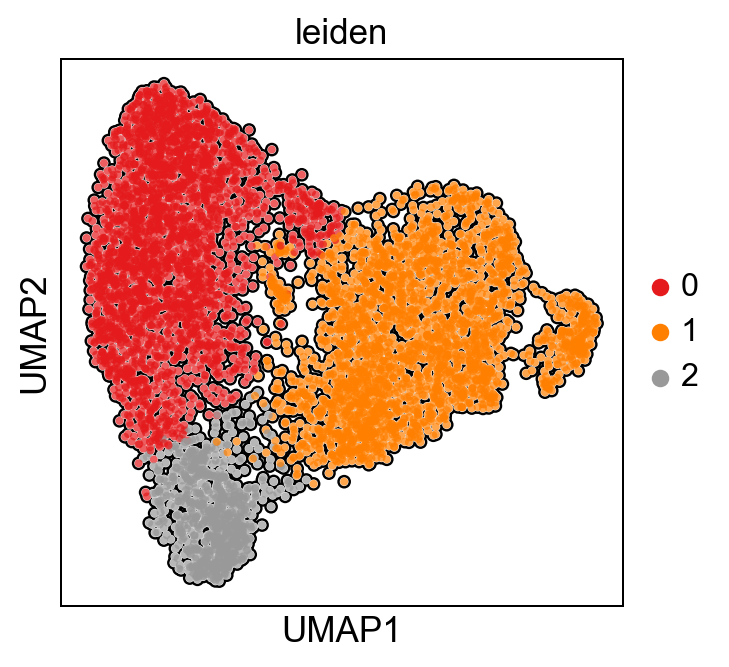

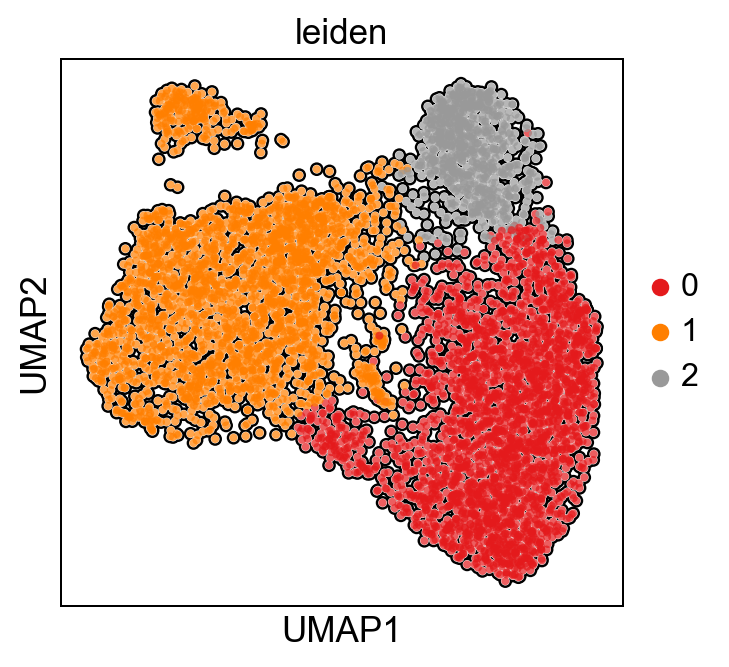

In [44]:
# original UMAP plot

sc.set_figure_params(dpi=90)
n_cells = ProtAct_original.shape[0]
dot_size = 120000 / n_cells*2
pyviper.pl.umap(ProtAct_original, color='leiden', palette="Set1", size=dot_size,add_outline=True) 

#Corrected UMAP plot

sc.set_figure_params(dpi=90)
n_cells = ProtAct_corrected.shape[0]
dot_size = 120000 / n_cells*2
pyviper.pl.umap(ProtAct_corrected, color='leiden', palette="Set1", size=dot_size,add_outline=True) 

In [46]:
NES_integrated = pyviper.pp.stouffer(ProtAct_original, "leiden", filter_by_feature_groups=["tfs","cotfs"], compute_pvals=False, return_as_df=True) # Stouffer integration 
NES_integrated 

filtered_proteins = NES_integrated.columns[~NES_integrated.columns.str.startswith('RP')].to_list() # Exclude columns starting with 'RP' from integrated matrix
NES_integrated = NES_integrated.loc[:,filtered_proteins] # remove ribosomal proteins from DataFrame

100%|██████████| 3/3 [00:00<00:00,  5.50it/s]


In [47]:
active_proteins = NES_integrated.apply(lambda row: row.nlargest(10).index.tolist(), axis=1)  # the top 10 most activated proteins in each cell type
active_proteins


0_scores    [INHBA, MMP14, ID3, LOXL2, HOPX, LEF1, RUNX2, ...
1_scores    [TSHZ2, NFIA, NFIB, ZBTB16, IGF1, TCF21, TSC22...
2_scores    [ENO1, NACA, PFDN5, BTF3, HMGA1, LOXL2, CCDC85...
dtype: object

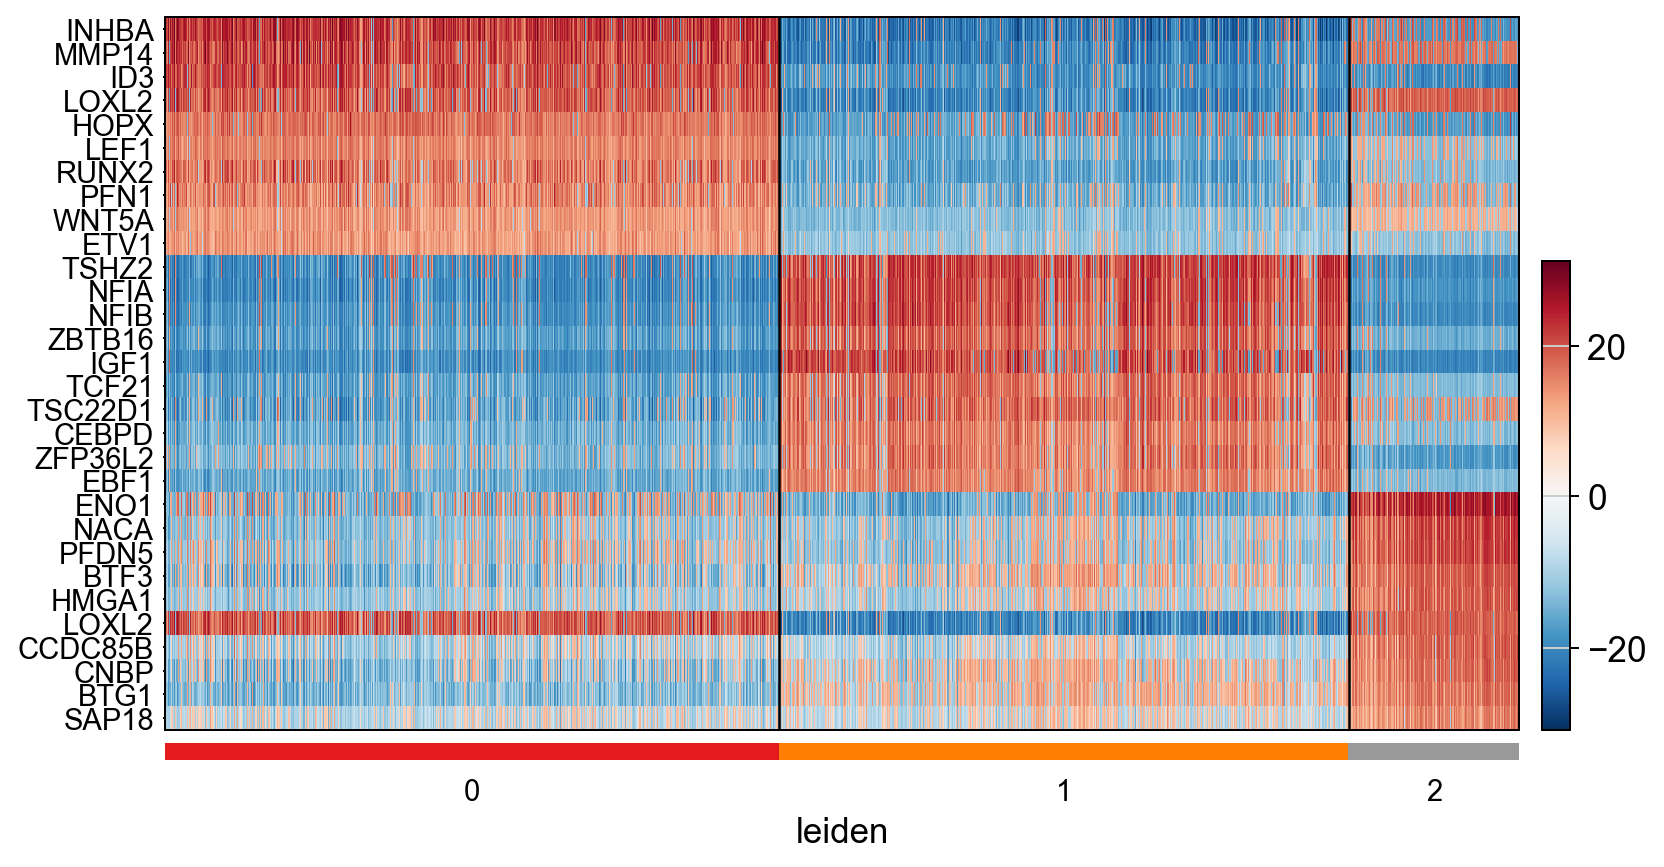

In [48]:
# Step 12: Plot heatmap of protein activity for the top 10 proteins in each cluster (original)
protein_set = active_proteins.sum() # protein set to display on the heatmap
ax = pyviper.pl.heatmap(ProtAct_original, var_names=protein_set, groupby="leiden", vcenter=0, cmap="RdBu_r",dendrogram=False,swap_axes=True, show_gene_labels=True)

In [49]:
NES_integrated = pyviper.pp.stouffer(ProtAct_corrected, "leiden", filter_by_feature_groups=["tfs","cotfs"], compute_pvals=False, return_as_df=True) # Stouffer integration 
NES_integrated 

filtered_proteins = NES_integrated.columns[~NES_integrated.columns.str.startswith('RP')].to_list() # Exclude columns starting with 'RP' from integrated matrix
NES_integrated = NES_integrated.loc[:,filtered_proteins] # remove ribosomal proteins from DataFrame

100%|██████████| 3/3 [00:00<00:00,  5.54it/s]


In [50]:
active_proteins = NES_integrated.apply(lambda row: row.nlargest(10).index.tolist(), axis=1)  # the top 10 most activated proteins in each cell type
active_proteins

0_scores    [INHBA, MMP14, ID3, LOXL2, HOPX, LEF1, RUNX2, ...
1_scores    [TSHZ2, NFIA, NFIB, ZBTB16, TCF21, IGF1, TSC22...
2_scores    [ENO1, NACA, PFDN5, LOXL2, BTF3, HMGA1, CCDC85...
dtype: object

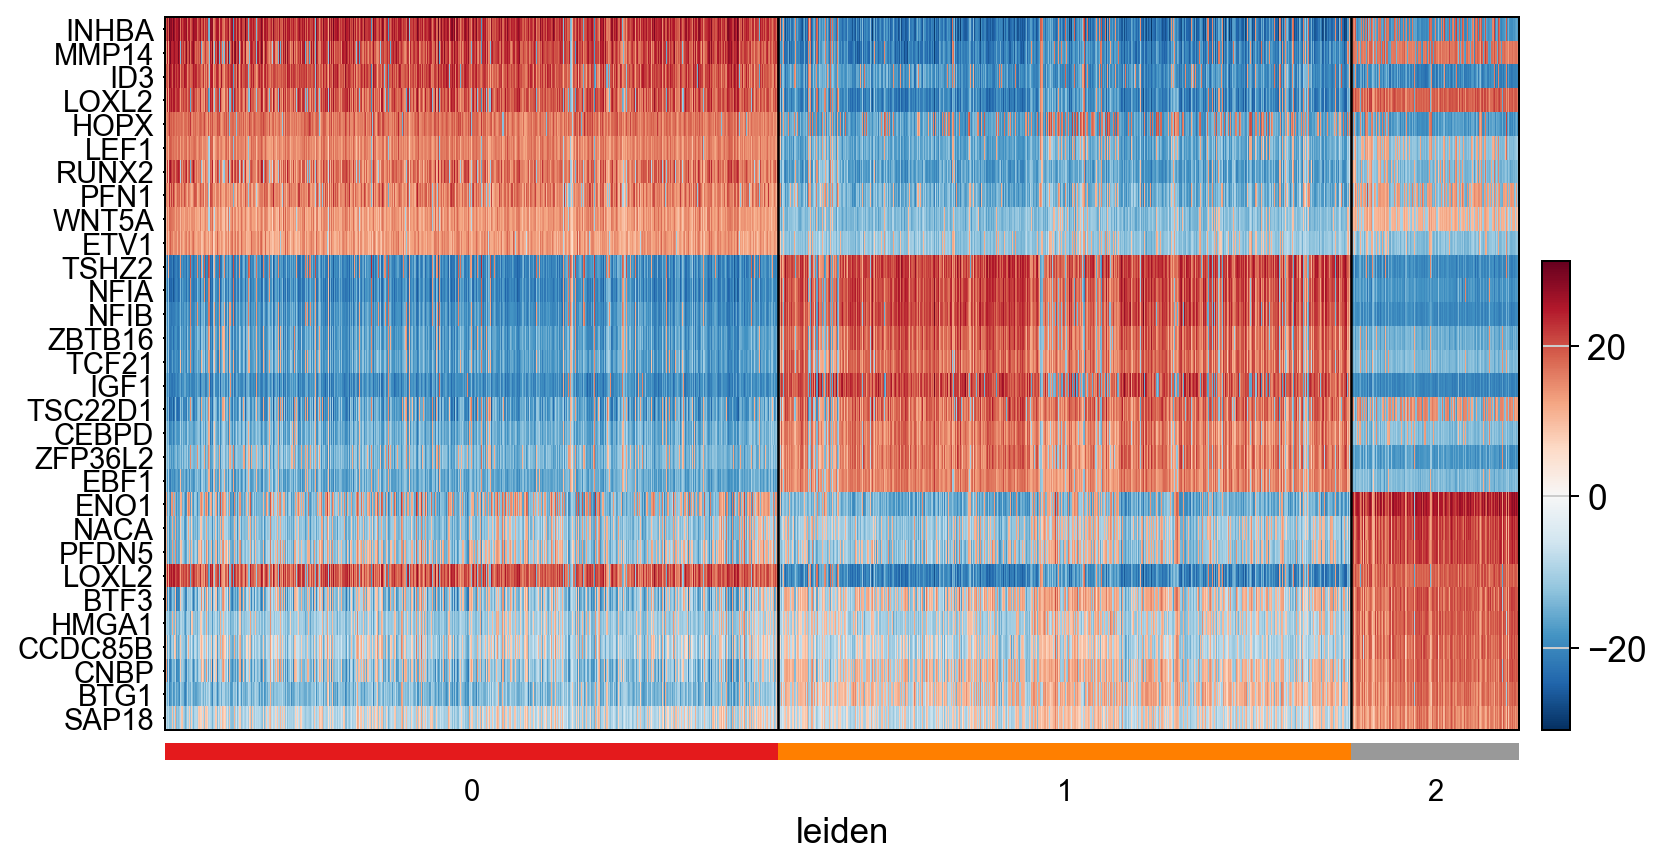

In [51]:
# Plot heatmap of protein activity for the top 10 proteins in each cluster (coprrected)
protein_set = active_proteins.sum() # protein set to display on the heatmap
ax = pyviper.pl.heatmap(ProtAct_corrected, var_names=protein_set, groupby="leiden", vcenter=0, cmap="RdBu_r",dendrogram=False,swap_axes=True, show_gene_labels=True)

In [ ]:
#missing = [gene for gene in protein_set if gene not in ProtAct_corrected.var_names]
#print("Missing proteins due to pleiotropy correction:", missing)


Missing proteins due to pleiotropy correction: []
